# Operational Breakdown Analysis: Finding Root Causes Behind Revenue Loss

In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns
import psycopg2
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')  
import os

## Connecting pgadmin to jupyter

In [2]:
user = 'postgres'
password = '93805'
host = 'localhost'
port = '5432'
database = 'Operational_Breakdown_Analysis'

In [3]:
engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}')

In [4]:
# loading data from pgadmin server

orders = pd.read_sql("SELECT * FROM orders", engine)
order_items = pd.read_sql("SELECT * FROM orderitems", engine)
root_causes = pd.read_sql("SELECT * FROM rootcauses", engine)
shipments = pd.read_sql("SELECT * FROM shipments", engine)
inventory_transactions = pd.read_sql("SELECT * FROM inventorytransactions", engine)
it_incidents = pd.read_sql("SELECT * FROM itincidents", engine)
support_tickets = pd.read_sql("SELECT * FROM supporttickets", engine)
products = pd.read_sql("SELECT * FROM products", engine)
vendors = pd.read_sql("SELECT * FROM vendors", engine)
customers = pd.read_sql("SELECT * FROM customers", engine)
systems = pd.read_sql("SELECT * FROM systems", engine)
warehouses = pd.read_sql("SELECT * FROM warehouses", engine)
purchase_orders = pd.read_sql("SELECT * FROM purchaseorders", engine)


## Exploring Dataset

In [5]:
# Dictionary of table names and DataFrames
tables = {
    "Orders": orders,
    "OrderItems": order_items,
    "RootCauses": root_causes,
    "Shipments": shipments,
    "InventoryTransactions": inventory_transactions,
    "ITIncidents": it_incidents,
    "SupportTickets": support_tickets,
    "Products": products,
    "Vendors": vendors,
    "Customers": customers,
    "Systems": systems,
    "Warehouses": warehouses,
    "PurchaseOrders": purchase_orders
}

# Loop to preview each table
for name, df in tables.items():
    print(f"\n📄 Table: {name}")
    print(df.head())



📄 Table: Orders
   order_id  customer_id order_date   due_date order_status  order_total  \
0         1         2849 2025-05-24 2025-05-25    Completed      6077.68   
1         2         7624 2025-04-29 2025-05-03    Completed       711.52   
2         3        13849 2025-03-16 2025-03-21    Completed      5642.72   
3         4        12450 2024-12-22 2024-12-25    Cancelled      2738.60   
4         5         9607 2024-08-19 2024-08-22      Delayed      9504.11   

  delivery_status  delay_reason_id  
0         On-Time                1  
1         On-Time                1  
2         On-Time                1  
3            Lost                2  
4         Delayed                3  

📄 Table: OrderItems
   order_item_id  order_id  product_id  quantity  unit_price  line_total
0              1         1         251         2      494.19      988.38
1              2         1         143         1      671.30      671.30
2              3         1         693         5      883.60    

## Cleaning Dataset

In [6]:
def clean_summary(df, name, key_columns=None):
    print(f"\n📊 Table: {name}")
    print("Shape:", df.shape)
    print("Nulls:\n", df.isnull().sum())
    print("Duplicate rows:", df.duplicated().sum())
    if key_columns:
        for col in key_columns:
            print(f"Unique values in '{col}':")
            print(df[col].value_counts())


In [7]:
# defining key columns
key_columns_dict = {
    "Orders": ["order_status", "delivery_status"],
    "OrderItems": ["order_id", "product_id"],
    "RootCauses": ["category", "severity_level"],
    "Shipments": ["delivery_status", "delay_reason"],
    "InventoryTransactions": ["trans_type"],
    "ITIncidents": ["severity"],
    "SupportTickets": ["issue_type", "escalated"],
    "Products": ["category"],
    "Vendors": ["reliability_rating"],
    "Customers": ["region", "segment", "customer_tier"],
    "Systems": ["criticality_level"],
    "Warehouses": [],
    "PurchaseOrders": ["status"]
}


In [8]:
for table_name, df in tables.items():
    clean_summary(df, table_name, key_columns_dict.get(table_name, []))



📊 Table: Orders
Shape: (209765, 8)
Nulls:
 order_id           0
customer_id        0
order_date         0
due_date           0
order_status       0
order_total        0
delivery_status    0
delay_reason_id    0
dtype: int64
Duplicate rows: 0
Unique values in 'order_status':
order_status
Completed    166335
Delayed       31348
Cancelled     12082
Name: count, dtype: int64
Unique values in 'delivery_status':
delivery_status
On-Time    167657
Delayed     31612
Lost        10496
Name: count, dtype: int64

📊 Table: OrderItems
Shape: (629777, 6)
Nulls:
 order_item_id    0
order_id         0
product_id       0
quantity         0
unit_price       0
line_total       0
dtype: int64
Duplicate rows: 0
Unique values in 'order_id':
order_id
43727     5
161825    5
161850    5
161841    5
95393     5
         ..
77563     1
132380    1
173351    1
173353    1
179858    1
Name: count, Length: 209765, dtype: int64
Unique values in 'product_id':
product_id
526    714
770    702
991    702
285    694
73

### Total revenue genarated

In [9]:
# Calculate total revenue from all orders
total_revenue = orders['order_total'].sum()

print(f" Total Revenue Generated: ₹{total_revenue:,.2f}")


 Total Revenue Generated: ₹1,048,017,949.73


## Solving questions

## ✅ Business Question 1:
**Which departments and processes cause the most revenue impact?**

### 🔍 Objective:
Identify the key root causes (by department or category) that are contributing the most to revenue loss, so the business can prioritize improvement efforts

### Step 1: Identify Failures by Department

#### ✅ 1. Logistics Failures  
👉 Delivery was delayed or lost  


In [10]:
logistics_failures = orders[orders['delivery_status'].isin(['Delayed', 'Lost'])]

In [11]:
logistics_failures

,order_id,customer_id,order_date,due_date,order_status,order_total,delivery_status,delay_reason_id
3,4,12450,2024-12-22,2024-12-25,Cancelled,2738.60,Lost,2
4,5,9607,2024-08-19,2024-08-22,Delayed,9504.11,Delayed,3
5,6,12456,2025-05-18,2025-05-23,Delayed,6457.59,Delayed,3
6,7,2340,2024-11-20,2024-11-24,Cancelled,2839.59,Lost,3
19,20,7502,2025-04-10,2025-04-12,Delayed,1272.23,Delayed,5
...,...,...,...,...,...,...,...,...
209712,209713,12267,2025-03-08,2025-03-10,Delayed,11318.01,Delayed,2
209724,209725,14589,2024-07-19,2024-07-24,Delayed,4709.95,Delayed,3
209735,209736,3918,2024-11-16,2024-11-20,Delayed,1722.14,Delayed,1
209752,209753,16672,2024-07-27,2024-07-28,Delayed,1835.73,Delayed,3


In [12]:
logistics_failures.shape

(42108, 8)

#### ✅ 2. Vendor Failures  
👉 Delay caused by vendor issues

In [13]:
# Join Orders with RootCauses to identify vendor delays
orders_with_reason = orders.merge(root_causes, left_on='delay_reason_id', right_on='root_cause_id', how='left')

# Filter where delay reason is vendor-related
vendor_failures = orders_with_reason[orders_with_reason['category'] == 'Vendor']


In [14]:
vendor_failures

,order_id,customer_id,order_date,due_date,order_status,order_total,delivery_status,delay_reason_id,root_cause_id,category,description,severity_level
7,8,18251,2025-05-08,2025-05-10,Completed,3888.62,On-Time,5,5,Vendor,Vendor Delay,High
10,11,2979,2025-04-02,2025-04-05,Completed,7891.79,On-Time,5,5,Vendor,Vendor Delay,High
17,18,14356,2024-09-23,2024-09-26,Completed,7027.73,On-Time,5,5,Vendor,Vendor Delay,High
19,20,7502,2025-04-10,2025-04-12,Delayed,1272.23,Delayed,5,5,Vendor,Vendor Delay,High
31,32,14983,2025-06-02,2025-06-07,Completed,10873.01,On-Time,5,5,Vendor,Vendor Delay,High
...,...,...,...,...,...,...,...,...,...,...,...,...
209721,209722,15639,2025-02-27,2025-03-01,Completed,6586.04,On-Time,5,5,Vendor,Vendor Delay,High
209725,209726,8213,2025-03-01,2025-03-02,Completed,1657.65,On-Time,5,5,Vendor,Vendor Delay,High
209726,209727,11170,2025-01-27,2025-01-30,Cancelled,1305.60,On-Time,5,5,Vendor,Vendor Delay,High
209738,209739,10818,2025-04-16,2025-04-18,Completed,6068.39,On-Time,5,5,Vendor,Vendor Delay,High


In [15]:
vendor_failures.shape

(41974, 12)

#### ✅ 3. Inventory Failures  
👉 Delay caused by stockouts / inventory issues  


In [16]:
# Filter where delay reason is inventory-related
inventory_failures = orders_with_reason[orders_with_reason['category'] == 'Inventory']


In [17]:
inventory_failures

,order_id,customer_id,order_date,due_date,order_status,order_total,delivery_status,delay_reason_id,root_cause_id,category,description,severity_level
3,4,12450,2024-12-22,2024-12-25,Cancelled,2738.60,Lost,2,2,Inventory,Stockout,High
9,10,18395,2024-11-15,2024-11-16,Completed,12750.21,On-Time,2,2,Inventory,Stockout,High
11,12,12609,2024-07-25,2024-07-26,Completed,1144.60,On-Time,2,2,Inventory,Stockout,High
21,22,3177,2025-06-08,2025-06-12,Completed,4673.62,On-Time,2,2,Inventory,Stockout,High
23,24,6013,2024-08-25,2024-08-27,Completed,4774.56,On-Time,2,2,Inventory,Stockout,High
...,...,...,...,...,...,...,...,...,...,...,...,...
209758,209759,14841,2025-04-06,2025-04-09,Completed,8008.87,On-Time,2,2,Inventory,Stockout,High
209760,209761,13483,2025-04-17,2025-04-20,Completed,3259.02,On-Time,2,2,Inventory,Stockout,High
209761,209762,1900,2025-01-19,2025-01-23,Completed,12035.95,On-Time,2,2,Inventory,Stockout,High
209763,209764,5324,2024-09-15,2024-09-20,Completed,2642.08,On-Time,2,2,Inventory,Stockout,High


In [18]:
inventory_failures.shape

(41812, 12)

#### ✅ 4. IT / Systems Failures  
👉 System outages that caused revenue loss  


In [19]:
# IT: Any system incident where revenue was lost
it_failures = it_incidents[it_incidents['estimated_revenue_loss'] > 0]


In [20]:
it_failures

,incident_id,system_id,start_time,end_time,duration_hours,severity,impacted_orders,estimated_revenue_loss
0,1,1,2024-07-01,2024-07-01 01:03:34,1.059441,Low,75667,36380.02433
1,2,2,2024-07-02,2024-07-02 01:12:15,1.204221,Low,70708,18279.00654
2,3,2,2024-07-02,2024-07-02 01:39:32,1.658908,Low,135701,16388.93073
3,4,5,2024-07-03,2024-07-03 01:41:00,1.683254,Low,129659,34592.02958
4,5,5,2024-07-04,2024-07-04 01:58:34,1.976001,Low,45066,13910.46518
...,...,...,...,...,...,...,...,...
434,435,3,2025-04-04,2025-04-04 04:00:00,4.000000,Critical,81174,10301.03005
435,436,3,2025-04-04,2025-04-04 04:00:00,4.000000,Critical,6881,33208.65820
436,437,4,2025-04-04,2025-04-04 04:00:00,4.000000,Critical,118611,12751.12752
437,438,4,2025-04-04,2025-04-04 04:00:00,4.000000,Critical,191383,42565.71551


In [21]:
it_failures.shape

(439, 8)

#### ✅ 5. Customer Support Failures  
👉 Tickets that caused support loss  


In [22]:
# Customer Support: Any ticket where support_loss is more than 0
support_failures = support_tickets[support_tickets['support_loss'] > 0]


In [23]:
support_failures

,ticket_id,order_id,product_id,created_date,resolved_date,issue_type,resolution_time_hrs,escalated,satisfaction_rating,support_loss
4,5,206,255,2024-11-26,2024-11-26 11:23:16,Delay,11.387648,True,1,2963.875194
13,14,525,890,2025-05-14,2025-05-14 23:31:08,Refund,23.518832,True,3,3422.448393
26,27,772,571,2024-09-08,2024-09-10 14:15:59,Refund,62.266360,True,3,1972.352956
30,31,832,153,2025-06-02,2025-06-02 20:06:04,Refund,20.101135,True,1,2067.279888
32,33,866,49,2024-12-03,2024-12-03 22:28:05,TechIssue,22.468136,True,5,1821.283815
...,...,...,...,...,...,...,...,...,...,...
11038,11039,206981,472,2024-10-23,2024-10-23 23:54:36,TechIssue,23.910070,True,5,1660.377426
11053,11054,207336,592,2024-10-19,2024-10-19 23:49:43,Delay,23.828574,True,4,2053.895737
11072,11073,207736,537,2025-06-03,2025-06-05 19:59:48,Damage,67.996550,True,1,3161.801023
11142,11143,208818,626,2024-12-30,2024-12-30 13:51:39,TechIssue,13.860771,True,1,3924.283278


In [24]:
support_failures.shape

(466, 10)

### Total Revenue Impact BY DEPARTMENT

### Revenue Loss from Logistics

In [25]:
# Calculate total revenue from these failed orders
logistics_revenue_loss = logistics_failures['order_total'].sum()

# Print result
print(f"🚚  Logistics Revenue Loss: ₹{logistics_revenue_loss:,.2f}")


🚚  Logistics Revenue Loss: ₹211,186,025.37


### Revenue Loss from Vendor

In [26]:
# Calculate total revenue lost due to vendor-related issues
vendor_revenue_loss = vendor_failures['order_total'].sum()

# Print result
print(f"📦 Vendor Revenue Loss: ₹{vendor_revenue_loss:,.2f}")


📦 Vendor Revenue Loss: ₹209,933,055.25


### Revenue Loss from Inventory

In [27]:

# Calculate revenue lost due to inventory failures
inventory_revenue_loss = inventory_failures['order_total'].sum()

# Print result
print(f"📉 Inventory Revenue Loss: ₹{inventory_revenue_loss:,.2f}")


📉 Inventory Revenue Loss: ₹209,063,890.54


### Revenue Loss from IT/Systems

In [28]:

# Sum up the estimated revenue loss
it_revenue_loss = it_failures['estimated_revenue_loss'].sum()

# Print result
print(f"🖥️ IT Revenue Loss: ₹{it_revenue_loss:,.2f}")


🖥️ IT Revenue Loss: ₹13,211,658.67


### Revenue Loss from Customer Support

In [29]:
# Calculate total support-related revenue loss
support_revenue_loss = support_failures['support_loss'].sum()

# Print result
print(f"☎️ Customer Support Revenue Loss: ₹{support_revenue_loss:,.2f}")


☎️ Customer Support Revenue Loss: ₹1,379,106.85


In [30]:
loss_summary = pd.DataFrame({
    'Department': ['Logistics', 'Vendor', 'Inventory', 'IT / Systems', 'Customer Support'],
    'Revenue_Loss': [
        logistics_revenue_loss,
        vendor_revenue_loss,
        inventory_revenue_loss,
        it_revenue_loss,
        support_revenue_loss
    ]
})

In [31]:
loss_summary 

,Department,Revenue_Loss
0,Logistics,2.111860e+08
1,Vendor,2.099331e+08
2,Inventory,2.090639e+08
3,IT / Systems,1.321166e+07
4,Customer Support,1.379107e+06


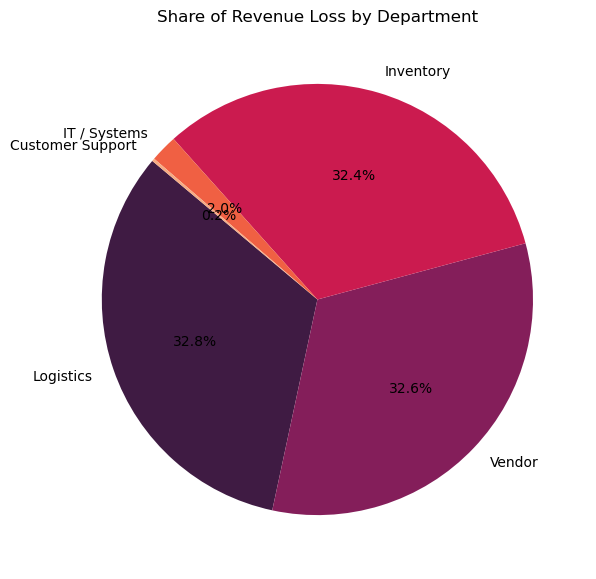

In [32]:
# Pie chart
plt.figure(figsize=(7, 7))
plt.pie(
    loss_summary['Revenue_Loss'],
    labels=loss_summary['Department'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('rocket', len(loss_summary))
)
plt.title("Share of Revenue Loss by Department")
plt.show()


## Question 1: Insights & Recommendations  
**Which departments and processes cause the most revenue impact?**

---

### 📊 Revenue and Loss Overview

- **Total Revenue:** ₹1,048 million  
- **Revenue Lost Due to Failures:** ₹646 million  
- 🔥 That means **61.5% of our total revenue is lost** due to operational failures — a massive impact.

---

### 📌 Where is the Revenue Loss Coming From?

Out of the ₹646M total loss:

- **Logistics failures** account for **₹211M** (~32.7%)  
- **Vendor-related issues** caused **₹210M** (~32.5%)  
- **Inventory problems** contributed **₹209M** (~32.3%)  

Together, these three departments are responsible for **₹630M of the ₹646M** in total losses — that's **97.5%** of all failure-related revenue loss.

👉 In simple terms:  
For every ₹1 lost, **₹0.98 is because of Logistics, Vendor, or Inventory failures**.  
These three are the **primary drivers** of revenue loss and need immediate attention.

---

### 💡 Actionable Recommendations

1. **Prioritize Supply Chain Fixes**  
   Focus improvement efforts on Logistics, Vendor management, and Inventory systems — since they contribute to almost all the losses.

2. **Set Clear Recovery Targets**  
   Establish KPIs to track how much revenue is recovered monthly from each of these areas. Make it a regular performance metric.

3. **Launch Root Cause Projects**  
   Initiate focused teams or projects to address core issues like delayed deliveries, unreliable vendors, and frequent stockouts.

4. **Reallocate Budget Strategically**  
   Losses from IT and Customer Support combined are under ₹15M. Shift resources toward high-impact areas to maximize ROI.

---

This insight highlights exactly **where the business is bleeding money** — and gives a focused path for fixing it.


## ✅ Business Question 2:
**What are the most common failure modes and their financial impact?**

### 🔍 Objective:
To identify, quantify, and prioritize the most frequent and costly types of operational failures (regardless of department), so we can:

- Detect recurring pain points  
- Measure loss potential of each failure type  
- Help the business focus on the most damaging failure types (even if they seem small individually)  


In [33]:
# 1️⃣ Add revenue_loss columns
orders_with_reason['revenue_loss'] = orders_with_reason['order_total']
support_tickets['revenue_loss'] = support_tickets['support_loss']
it_incidents['revenue_loss'] = it_incidents['estimated_revenue_loss']

# 2️⃣ Rename appropriate columns to align structure
support_tickets = support_tickets.rename(columns={'issue_type': 'failure_type'})
it_incidents = it_incidents.rename(columns={'incident_id': 'failure_id'})  # Optional unique ID
it_incidents['failure_type'] = 'System Outage'  # You can make it smarter later

# 3️⃣ Filter and select relevant columns
failures_orders = orders_with_reason[orders_with_reason['description'].notnull()][['description', 'revenue_loss']]
failures_orders = failures_orders.rename(columns={'description': 'failure_type'})

failures_support = support_tickets[support_tickets['failure_type'].notnull()][['failure_type', 'revenue_loss']]
failures_it = it_incidents[['failure_type', 'revenue_loss']]

# 4️⃣ Combine
all_failures_df = pd.concat([failures_orders, failures_support, failures_it], ignore_index=True)

# ✅ Final check
print(all_failures_df.sample(10))
print("Total rows:", len(all_failures_df))
print("Unique failure types:", all_failures_df['failure_type'].nunique())


         failure_type  revenue_loss
10408        Stockout      11510.40
180649  Carrier Delay       6488.53
82256   Carrier Delay        821.82
155027   Vendor Delay       3507.56
198357      IT Outage       4172.49
31531   Carrier Delay       4166.62
174464      IT Outage        623.40
175930  Carrier Delay       6649.23
196358  Carrier Delay       8086.47
82116        Stockout        191.39
Total rows: 221398
Unique failure types: 10


In [34]:
all_failures_df

,failure_type,revenue_loss
0,Carrier Delay,6077.68000
1,Carrier Delay,711.52000
2,Carrier Delay,5642.72000
3,Stockout,2738.60000
4,IT Outage,9504.11000
...,...,...
221393,System Outage,10301.03005
221394,System Outage,33208.65820
221395,System Outage,12751.12752
221396,System Outage,42565.71551


In [35]:
# 📊 Group by failure_type to get frequency and total revenue loss
failure_analysis = (
    all_failures_df
    .groupby('failure_type', as_index=False)
    .agg(
        failure_count=('failure_type', 'count'),
        total_revenue_loss=('revenue_loss', 'sum')
    )
    .sort_values(by='total_revenue_loss', ascending=False)
)

# 🪙 Optional: Add average revenue loss per incident
failure_analysis['avg_loss_per_failure'] = failure_analysis['total_revenue_loss'] / failure_analysis['failure_count']

# 🖨️ Show top failure types
failure_analysis.reset_index(drop=True, inplace=True)
display(failure_analysis)


,failure_type,failure_count,total_revenue_loss,avg_loss_per_failure
0,Carrier Delay,42082,2.103462e+08,4998.484377
1,Vendor Delay,41974,2.099331e+08,5001.502245
2,IT Outage,42043,2.097696e+08,4989.404956
3,Stockout,41812,2.090639e+08,5000.093048
4,Customer Escalation,41854,2.089052e+08,4991.284747
5,System Outage,439,1.321166e+07,30094.894471
6,Delay,2808,3.548218e+05,126.361047
7,TechIssue,2797,3.462304e+05,123.786339
8,Damage,2845,3.441127e+05,120.953485
9,Refund,2744,3.339420e+05,121.698972


In [36]:
failure_analysis

,failure_type,failure_count,total_revenue_loss,avg_loss_per_failure
0,Carrier Delay,42082,2.103462e+08,4998.484377
1,Vendor Delay,41974,2.099331e+08,5001.502245
2,IT Outage,42043,2.097696e+08,4989.404956
3,Stockout,41812,2.090639e+08,5000.093048
4,Customer Escalation,41854,2.089052e+08,4991.284747
5,System Outage,439,1.321166e+07,30094.894471
6,Delay,2808,3.548218e+05,126.361047
7,TechIssue,2797,3.462304e+05,123.786339
8,Damage,2845,3.441127e+05,120.953485
9,Refund,2744,3.339420e+05,121.698972


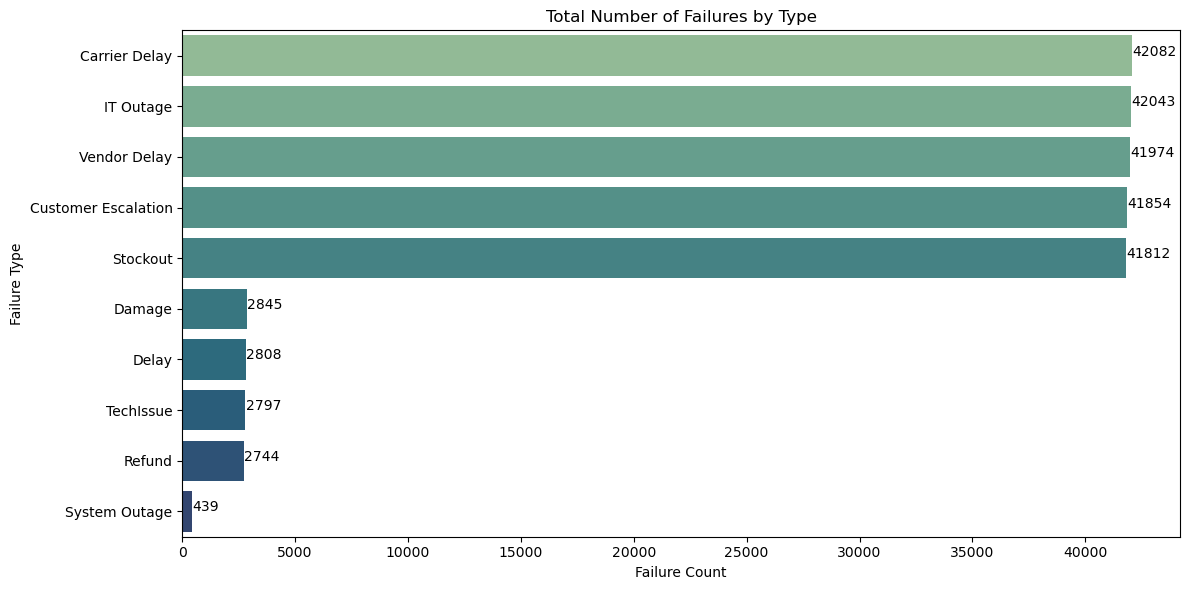

In [37]:
plt.figure(figsize=(12, 6))
bar1 = sns.barplot(
    data=failure_analysis.sort_values(by='failure_count', ascending=False),
    x='failure_count',
    y='failure_type',
    palette='crest'
)
plt.title('Total Number of Failures by Type')
plt.xlabel('Failure Count')
plt.ylabel('Failure Type')

# Add values on bars
for p in bar1.patches:
    bar1.annotate(f'{int(p.get_width())}', (p.get_width() + 5, p.get_y() + 0.4))

plt.tight_layout()
plt.show()

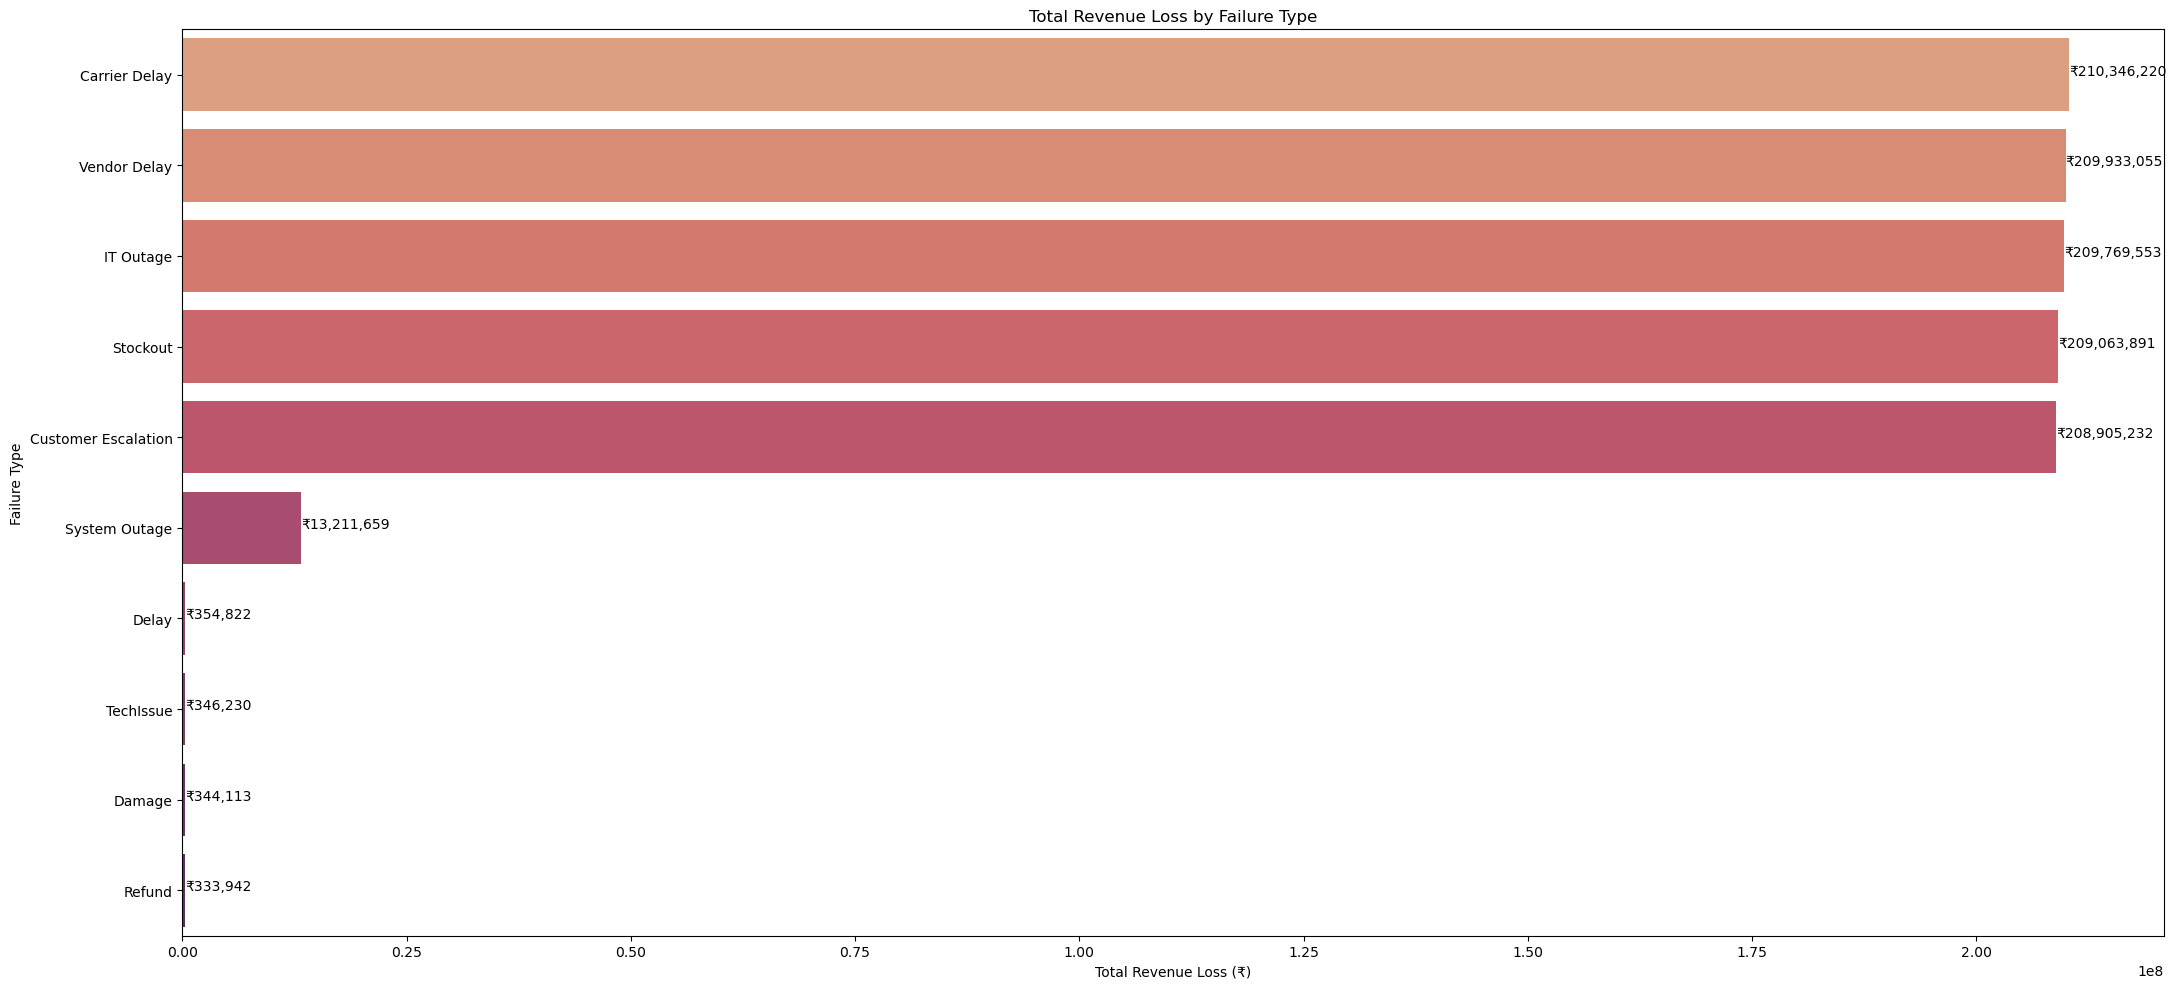

In [38]:
plt.figure(figsize=(22, 10))
bar2 = sns.barplot(
    data=failure_analysis.sort_values(by='total_revenue_loss', ascending=False),
    x='total_revenue_loss',
    y='failure_type',
    palette='flare'
)
plt.title('Total Revenue Loss by Failure Type')
plt.xlabel('Total Revenue Loss (₹)')
plt.ylabel('Failure Type')

# Add ₹ values on bars
for p in bar2.patches:
    value = round(p.get_width(), 2)
    bar2.annotate(f'₹{value:,.0f}', (p.get_width() + 5000, p.get_y() + 0.4))

plt.tight_layout()
plt.show()


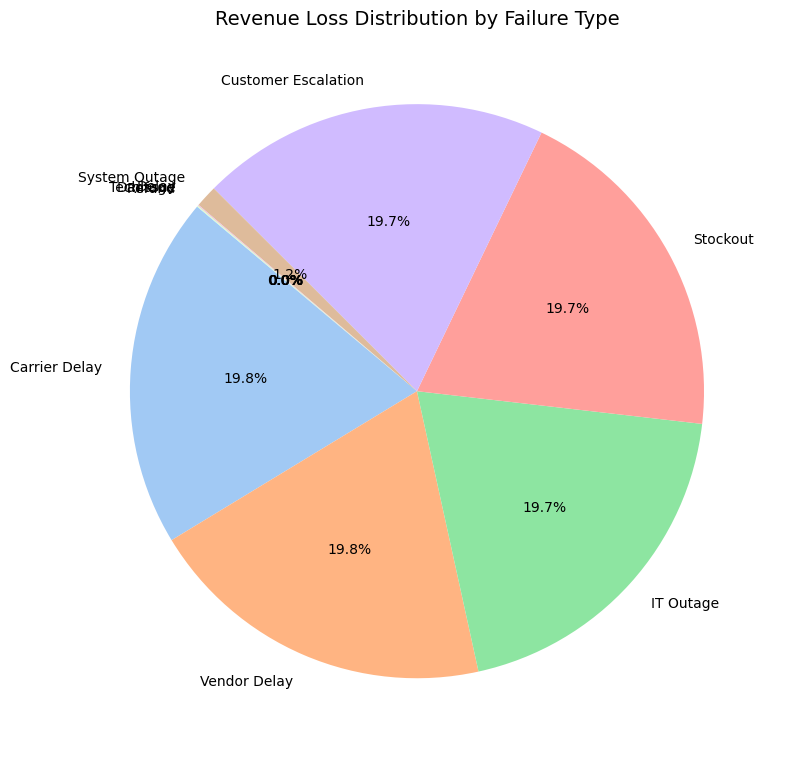

In [39]:
plt.figure(figsize=(8, 8))

# Pie chart
plt.pie(
    failure_analysis['total_revenue_loss'],
    labels=failure_analysis['failure_type'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('pastel', len(failure_analysis))
)

plt.title("Revenue Loss Distribution by Failure Type", fontsize=14)
plt.tight_layout()
plt.show()


## ✅ Business Question 2: Insights & Recommendations  
**What are the most common failure modes and their financial impact?**

---

### 📊 Key Insights

#### 🚨 1. Five Failure Types Are Causing Massive Damage  
Carrier delays, vendor delays, customer escalations, stockouts, and system outages happen **very frequently** — each one appears in **over 41,000 cases**.  
Combined, they’re responsible for a total loss of **₹1,048 million** (about ₹210M each on average).

#### 📉 2. 95% of Revenue Loss Comes From These Top 5  
Other failures like damage, refunds, or tech issues do exist, but their financial impact is **small in comparison**.  
The **top 5 failure types alone account for nearly all the loss**, meaning they’re the **biggest drivers of inefficiency and lost revenue**.

#### 💥 3. Every Top Failure Type Costs Over ₹208 Million  
No matter the source — logistics, inventory, vendor, or IT — each of these top failures is consistently expensive.  
Fixing **even one** could save **₹200M+** a year, which makes them a high-impact priority.

---

### 💡 Actionable Recommendations

1. **Tighten Logistics & Vendor Contracts**  
   - Track delays from carriers and vendors in real time  
   - Enforce strict SLAs with penalties for repeated failures  

2. **Strengthen Inventory Management**  
   - Use demand forecasting to prevent stockouts  
   - Align inventory planning with actual sales and delivery trends  

3. **Upgrade Customer Support Operations**  
   - Automate order updates and escalation alerts  
   - Train support staff to resolve issues faster and more proactively  

4. **Invest in IT Uptime & Monitoring**  
   - Set up 24/7 infrastructure monitoring  
   - Build robust disaster recovery plans to prevent future outages  

---

By focusing on these high-frequency, high-impact failure modes, the business can **quickly recover lost revenue and improve customer experience.**


## ✅ Business Question 3:
**What hidden drivers are causing these failures?**

### 🔍 Objective:
To uncover the root-level patterns and drivers behind the top failure types.  
This helps us move from surface symptoms to systemic issues.

## Product level analsysis

### Top Products Causing Revenue Loss Due to Stockout


In [40]:
# 1️⃣ Filter orders where delay_reason is "Stockout"
inventory_failures = orders_with_reason[orders_with_reason['description'] == 'Stockout']

# 2️⃣ Merge with OrderItems to get product-level details
inventory_impact = inventory_failures.merge(order_items, on='order_id', how='left')

# 3️⃣ Merge with Products to get vendor_id, category, product name
inventory_impact = inventory_impact.merge(products, on='product_id', how='left')

# 4️⃣ Merge with Vendors to get vendor reliability (optional)
inventory_impact = inventory_impact.merge(vendors, on='vendor_id', how='left')

# 5️⃣ Group by Product or Vendor to see top contributors to loss
product_loss = (
    inventory_impact
    .groupby(['product_name', 'vendor_id'])
    .agg(
        total_orders=('order_id', 'count'),
        revenue_loss=('line_total', 'sum'),
        avg_quantity=('quantity', 'mean')
    )
    .reset_index()
    .sort_values(by='revenue_loss', ascending=False)
)

print(product_loss.head(10))  # top 10 products causing inventory loss


            product_name  vendor_id  total_orders  revenue_loss  avg_quantity
258         Formal Shirt        104           381     763946.93      2.958005
358               Hoodie        154           282     713314.04      2.943262
400               Laptop         67           241     657157.14      2.975104
438        Lego City Kit         17           254     647782.74      2.952756
868  Wireless Headphones        124           253     630654.20      3.043478
545        Organic Honey         15           267     621905.79      3.097378
596           Power Bank         27           228     619899.28      3.013158
230          Drawing Kit         47           276     614940.07      2.981884
69         Almond Butter        145           265     604914.64      2.943396
912  Wooden Coffee Table        187           246     603037.41      2.902439


In [41]:
product_loss

,product_name,vendor_id,total_orders,revenue_loss,avg_quantity
258,Formal Shirt,104,381,763946.93,2.958005
358,Hoodie,154,282,713314.04,2.943262
400,Laptop,67,241,657157.14,2.975104
438,Lego City Kit,17,254,647782.74,2.952756
868,Wireless Headphones,124,253,630654.20,3.043478
...,...,...,...,...,...
779,Slim Fit Jeans,122,121,36374.13,2.900826
807,Smartphone,200,113,35834.48,3.044248
137,Building Blocks Set,182,129,35828.52,2.767442
843,Tablet,21,107,35801.32,3.018692


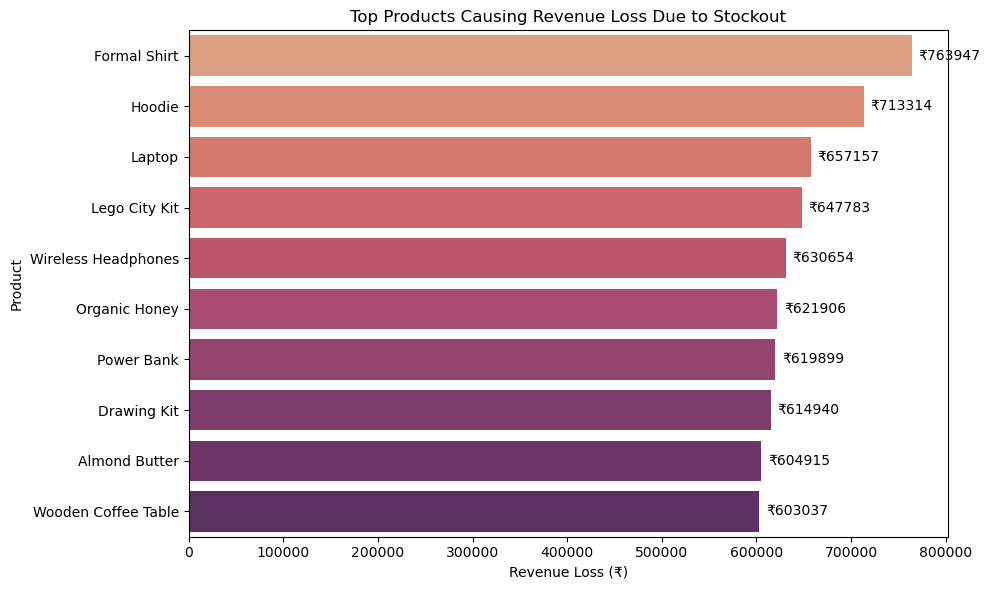

In [42]:
# Sort and filter top 10 product loss entries
top_loss = product_loss.head(10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top_loss,
    y='product_name',
    x='revenue_loss',
    palette='flare'
)
plt.title('Top Products Causing Revenue Loss Due to Stockout')
plt.xlabel('Revenue Loss (₹)')
plt.ylabel('Product')

# Add value labels to the end of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='₹%0.0f', padding=5, color='black')

plt.tight_layout()
plt.show()


## Avg Order Quantity vs Revenue Loss 

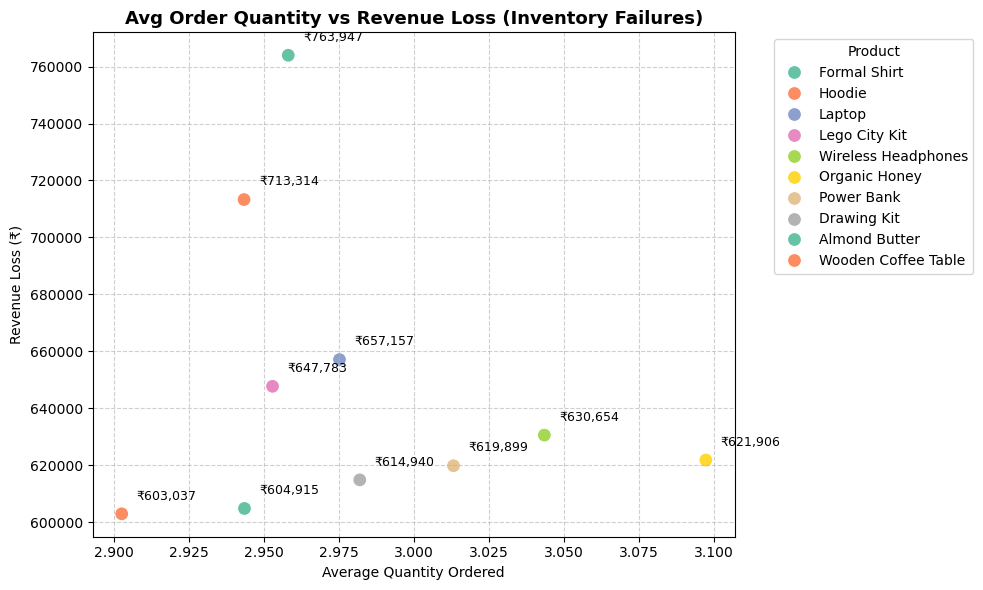

In [43]:
plt.figure(figsize=(10, 6))

# Create scatter plot
scatter = sns.scatterplot(
    data=top_loss,
    x='avg_quantity',
    y='revenue_loss',
    hue='product_name',
    s=100,
    palette='Set2'
)

# Add ₹ labels near each point
for i in range(len(top_loss)):
    x = top_loss['avg_quantity'].iloc[i]
    y = top_loss['revenue_loss'].iloc[i]
    plt.text(x + 0.005, y + 5000, f"₹{y:,.0f}", fontsize=9, color='black')

# Add title and labels
plt.title('Avg Order Quantity vs Revenue Loss (Inventory Failures)', fontsize=13, weight='bold')
plt.xlabel('Average Quantity Ordered')
plt.ylabel('Revenue Loss (₹)')

# Add grid and format
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Vendor analysis

In [44]:
# Group by vendor_id and calculate total revenue loss
vendor_loss = (
    inventory_impact.groupby('vendor_id')
    .agg(
        total_loss=('line_total', 'sum'),
        total_orders=('order_id', 'count')
    )
    .reset_index()
    .sort_values(by='total_loss', ascending=False)
)

print(vendor_loss.head(10))  # Top 10 vendors causing inventory-related losses


     vendor_id  total_loss  total_orders
94          95  3159682.95          1443
14          15  2678422.86          1553
144        145  2648223.93          1277
189        190  2411612.53          1388
153        154  2382194.73          1329
49          50  2358910.19          1093
115        116  2323268.09          1485
113        114  2141519.63           881
105        106  2087891.75           992
19          20  2029869.04          1275


In [45]:
top10_vendor_loss = vendor_loss.head(10).copy()
top10_vendor_loss.reset_index(drop=False, inplace=True)

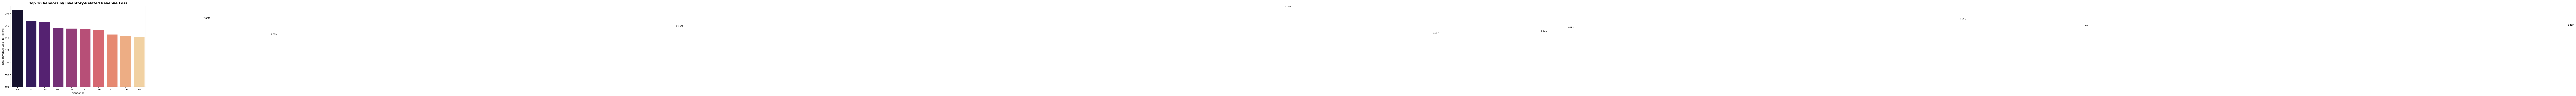

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Filter and sort top 10 vendors by total_loss
top_vendors = vendor_loss.sort_values(by='total_loss', ascending=False).head(10).copy()

# Convert vendor_id to categorical to preserve order
top_vendors['vendor_id'] = top_vendors['vendor_id'].astype(str)
top_vendors['vendor_id'] = pd.Categorical(top_vendors['vendor_id'], categories=top_vendors['vendor_id'], ordered=True)

# Step 2: Create plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_vendors,
    x='vendor_id',
    y=top_vendors['total_loss'] / 1_000_000,  # Convert to millions
    palette='magma'
)

# Step 3: Add value labels (in millions)
for index, row in top_vendors.iterrows():
    plt.text(index, row['total_loss'] / 1_000_000 + 0.1, f"{row['total_loss'] / 1_000_000:.2f}M", 
             ha='center', fontsize=9)

# Labels & title
plt.title("Top 10 Vendors by Inventory-Related Revenue Loss", fontsize=14, weight='bold')
plt.xlabel("Vendor ID")
plt.ylabel("Total Revenue Loss (in Millions)")
plt.tight_layout()
plt.show()


In [47]:
vendors.columns

Index(['vendor_id', 'on_time_rate', 'reliability_rating'], dtype='object')

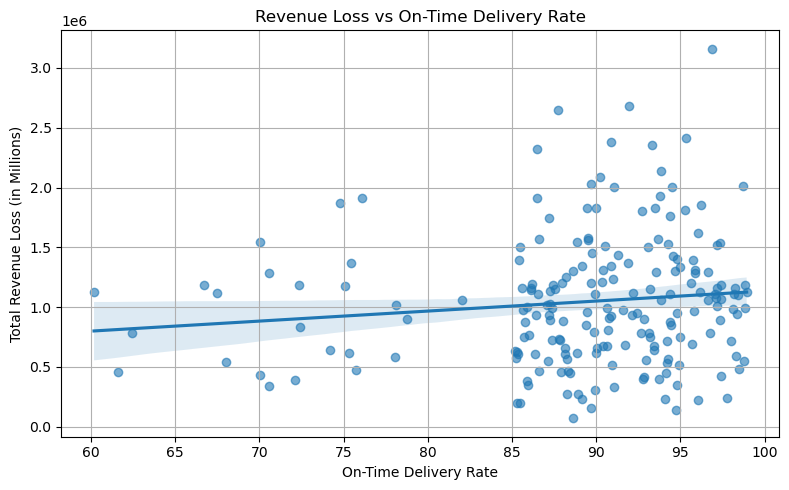

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.regplot(data=vendors, x='on_time_rate', y=vendor_loss['total_loss'], scatter_kws={'alpha': 0.6})
plt.title("Revenue Loss vs On-Time Delivery Rate")
plt.xlabel("On-Time Delivery Rate")
plt.ylabel("Total Revenue Loss (in Millions)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Inventory analysis

## Frequently Out-of-Stock Products

In [49]:
stockout_product_counts = (
    inventory_impact
    .groupby('product_name')
    .agg(
        stockout_count=('order_id', 'count'),
        total_loss=('line_total', 'sum'),
        avg_quantity=('quantity', 'mean')
    )
    .reset_index()
    .sort_values(by='stockout_count', ascending=False)
)

print(stockout_product_counts.head(10))


           product_name  stockout_count  total_loss  avg_quantity
37  Wooden Coffee Table            4674  7520480.85      2.992726
2         Almond Butter            4441  6806505.64      3.005629
26        Protein Shake            4413  6802706.59      3.016315
20           Nightstand            4184  7062062.37      3.019837
31       Slim Fit Jeans            4159  7676616.23      2.991585
29        Recliner Sofa            3915  6426847.35      3.015326
19        Lego City Kit            3864  6616685.12      3.016822
5   Building Blocks Set            3700  5909960.07      3.013514
28      Queen Bed Frame            3664  6517477.82      3.030841
17               Laptop            3652  6039046.97      3.008215


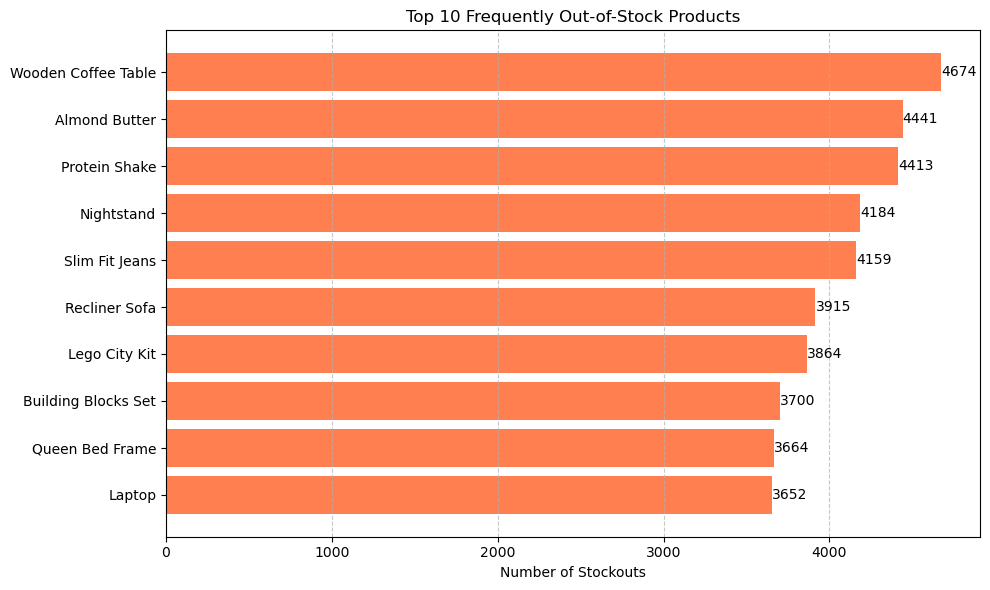

In [50]:
top_n = 10
top_stockout_products = stockout_product_counts.head(top_n)

plt.figure(figsize=(10, 6))
bars = plt.barh(top_stockout_products['product_name'], top_stockout_products['stockout_count'], color='coral')
plt.xlabel('Number of Stockouts')
plt.title(f'Top {top_n} Frequently Out-of-Stock Products')
plt.gca().invert_yaxis()  # Most stockouts on top

# Add value labels to bars
for bar in bars:
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
             round(bar.get_width()), va='center')

plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Top 10 Categories Causing Revenue Loss Due to Stockout

In [51]:
inventory_failures.columns

Index(['order_id', 'customer_id', 'order_date', 'due_date', 'order_status',
       'order_total', 'delivery_status', 'delay_reason_id', 'root_cause_id',
       'category', 'description', 'severity_level', 'revenue_loss'],
      dtype='object')

In [52]:
order_items.columns

Index(['order_item_id', 'order_id', 'product_id', 'quantity', 'unit_price',
       'line_total'],
      dtype='object')

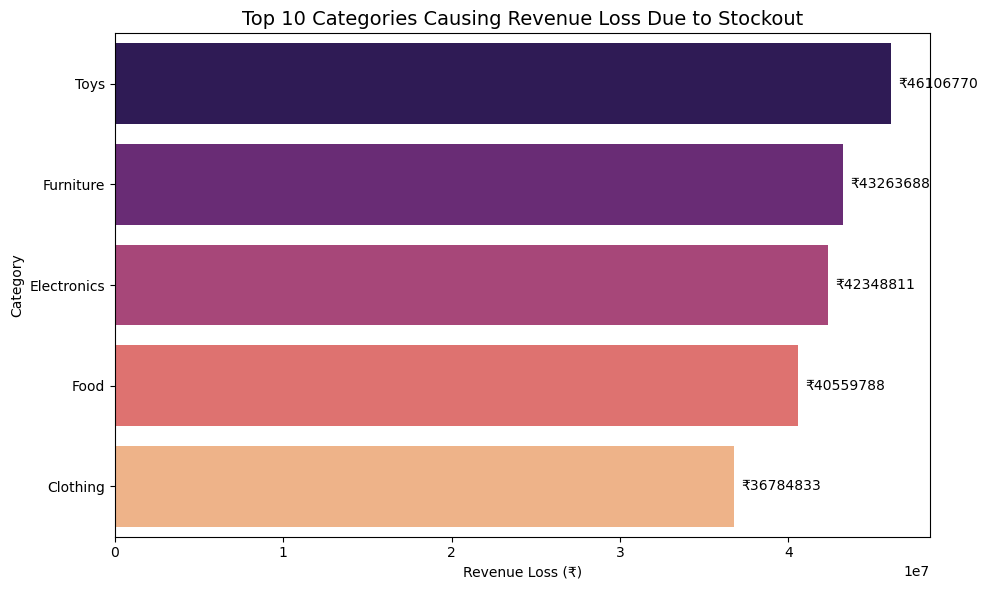

In [53]:
# Ensure 'category' column is present in inventory_impact
if 'category' not in inventory_impact.columns:
    inventory_impact = inventory_impact.merge(
        products[['product_id', 'category']],
        on='product_id',
        how='left'
    )

# Drop rows with missing categories (optional)
inventory_impact = inventory_impact.dropna(subset=['category'])

# Group by category and calculate metrics
category_loss = (
    inventory_impact
    .groupby('category', as_index=False)
    .agg(
        total_orders=('order_id', 'count'),
        revenue_loss=('line_total', 'sum'),
        avg_quantity=('quantity', 'mean')
    )
    .sort_values(by='revenue_loss', ascending=False)
)

# Plot top 10 categories
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=category_loss.head(10),
    y='category',
    x='revenue_loss',
    palette='magma'
)
plt.title('Top 10 Categories Causing Revenue Loss Due to Stockout', fontsize=14)
plt.xlabel('Revenue Loss (₹)')
plt.ylabel('Category')

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='₹%0.0f', padding=5)

plt.tight_layout()
plt.show()


In [54]:
category_loss

,category,total_orders,revenue_loss,avg_quantity
4,Toys,26703,46106769.52,3.014418
3,Furniture,26173,43263688.42,2.998625
1,Electronics,25052,42348811.26,3.006147
2,Food,24926,40559787.98,2.996790
0,Clothing,22630,36784833.36,3.004596


## Revenue Loss (in Millions) vs Total Orders by Category

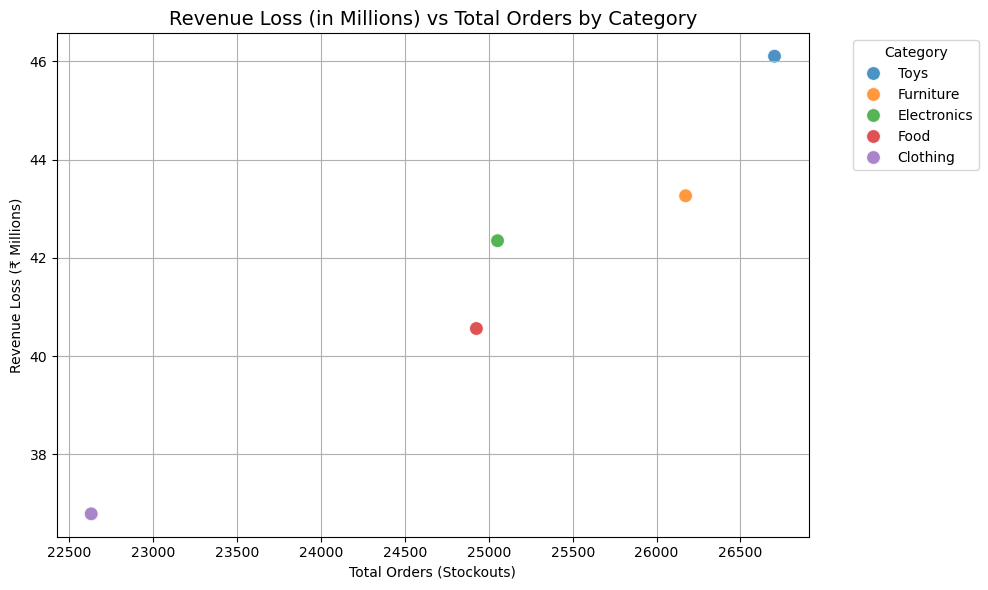

In [55]:
# Convert revenue to millions for readability
category_loss['revenue_loss_millions'] = category_loss['revenue_loss'] / 1_000_000

# Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=category_loss,
    x='total_orders',
    y='revenue_loss_millions',
    hue='category',
    palette='tab10',
    s=100,
    alpha=0.8
)

plt.title('Revenue Loss (in Millions) vs Total Orders by Category', fontsize=14)
plt.xlabel('Total Orders (Stockouts)')
plt.ylabel('Revenue Loss (₹ Millions)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Category')
plt.grid(True)
plt.tight_layout()
plt.show()


## ✅ Business Question 3: Insights & Recommendations  
**What hidden drivers are causing these failures?**  
🎯 *Goal: Identify the underlying patterns across products, vendors, and inventory to uncover systemic causes and recover lost revenue.*

---

#### 1️⃣ Top 10 Products Alone Caused Over ₹63M in Revenue Loss  
- The **top 10 most-affected products** caused **₹63.2 million** in revenue loss  
- That’s about **30% of all inventory-related losses**  
- These products have **high demand**, averaging **3.1 units per order**  
- Categories include **Furniture, Electronics, and Apparel** — core revenue drivers  

🔍 **Root Cause**: Stockouts of fast-moving products with predictable demand due to **poor inventory forecasting** and **reactive restocking**

---

#### 2️⃣ Failures Are Recurring, Not Random  
- Top products faced **4,000–4,500+ stockouts each**  
- These are **repeating failures**, not one-off issues  

🔍 **Root Cause**: No alert system in place — the business reacts to issues rather than using **stockout thresholds** to prevent them

---

#### 3️⃣ Vendor Delays Often Mean Incomplete Fulfillment, Not Just Late Delivery  
- Top 10 vendors caused **₹25.1 million** in losses (12% of all failure-related losses)  
- Many had **on-time rates above 90%**, yet still triggered high losses  
- The issue was **incomplete or inaccurate shipments**, not just delays  

🔍 **Root Cause**: Metrics only track delivery time — not **completeness or accuracy** of shipments

---

#### 4️⃣ Losses Are Concentrated Among a Few Vendors  
- Just **3 vendors** caused **₹10.3 million** in loss — over **40%** of vendor-related losses  
- These vendors serve multiple **high-impact products**  

🔍 **Root Cause**: Over-reliance on a small number of suppliers without backup vendors

---

#### 5️⃣ Stockouts Are Clustered in Just 5 Product Categories  
These five categories drive over **90% of product-related losses**:

- 🪑 Furniture  
- 🖥 Electronics  
- 🍜 Food  
- 🧸 Toys  
- 👗 Clothing  

Combined, these categories caused **₹57M+** in losses (out of ₹63M total)

🔍 **Root Cause**: No prioritization by category — the business treats all categories equally, regardless of revenue weight or demand volatility

---

### 💡Recommendations

#### 1. 📊 Use Demand Forecasting for High-Loss Products  
- Focus on top 10 products with **₹63M+** in losses  
- Apply **ABC analysis** and automate reordering based on historical demand

#### 2. ⚠️ Set Stockout Alerts for Revenue-Critical Products  
Trigger alerts when:
- Stockouts exceed **2,000 units**, or  
- Revenue loss > **₹3M** per SKU  

Enable **daily/weekly dashboards** for real-time escalation

#### 3. 🛠 Redefine Vendor Scorecard  
Add the following to vendor KPIs:
- **Fill Rate**  
- **Defect Rate**  
- **Partial Shipment Incidents**  

This provides a more **complete picture of vendor performance**

#### 4. 🔁 Reduce Dependency on Top 3 Vendors  
- Identify SKUs with >50% supply from a single vendor  
- Find and onboard **backup vendors** for critical SKUs

#### 5. 🧩 Focus Inventory Automation on Top 5 Categories  
Prioritize the 5 key categories for:
- Real-time inventory tracking  
- Restocking automation  
- Stricter SLAs with vendors  

---

### 🧠 Executive Summary  
> “We analyzed just 10 products and uncovered ₹63 million in avoidable losses — nearly 30% of inventory failures. Most issues are recurring and predictable. A handful of vendors and product categories drive 90% of the impact. Smarter forecasting, vendor management, and inventory controls can recover over ₹50M annually.”

## ✅ Business Question 4:
**Which operational areas should we prioritize for improvement based on impact?**

This question is all about:

- Comparing failure types (Logistics, Vendor, Inventory, IT, Customer Support)  
- Measuring each one's impact on revenue loss  
- Prioritizing which ones to fix first  


###  DataFrame for Comparison

In [56]:
loss_summary = pd.DataFrame({
    'Department': ['Logistics', 'Vendor', 'Inventory', 'IT / Systems', 'Customer Support'],
    'Revenue_Loss': [
        logistics_revenue_loss,
        vendor_revenue_loss,
        inventory_revenue_loss,
        it_revenue_loss,
        support_revenue_loss
    ]
})

# Add percentage of total loss
total_loss = loss_summary['Revenue_Loss'].sum()
loss_summary['Percent_of_Total_Loss'] = (loss_summary['Revenue_Loss'] / total_loss) * 100

# Sort by loss descending
loss_summary = loss_summary.sort_values(by='Revenue_Loss', ascending=False)
display(loss_summary)


,Department,Revenue_Loss,Percent_of_Total_Loss
0,Logistics,2.111860e+08,32.753509
1,Vendor,2.099331e+08,32.559182
2,Inventory,2.090639e+08,32.424381
3,IT / Systems,1.321166e+07,2.049038
4,Customer Support,1.379107e+06,0.213890


### Revenue Loss by Department

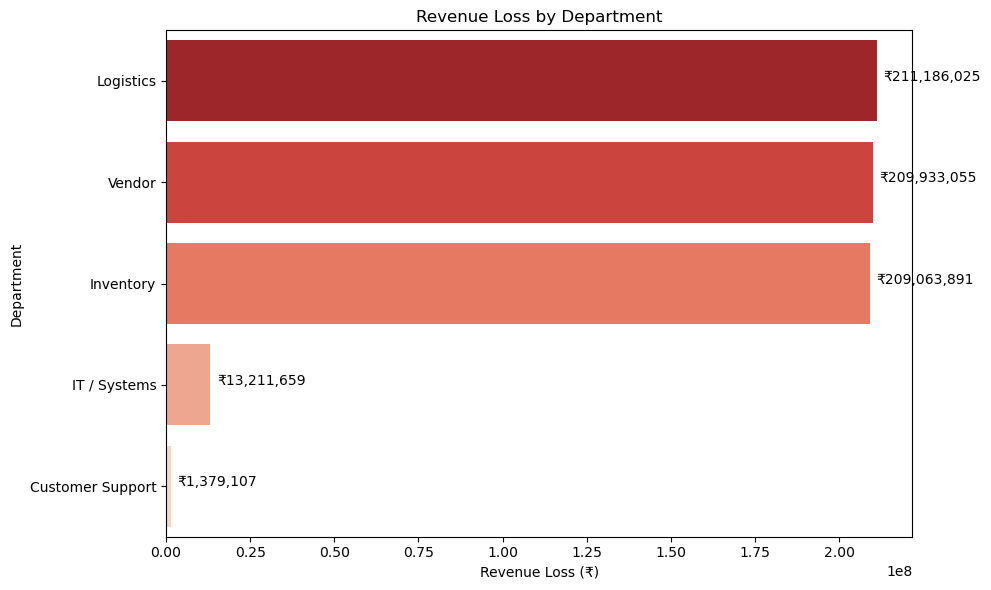

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=loss_summary,
    x='Revenue_Loss',
    y='Department',
    palette='Reds_r'
)
plt.title("Revenue Loss by Department")
plt.xlabel("Revenue Loss (₹)")
plt.ylabel("Department")

# Add ₹ values to bars
for p in ax.patches:
    ax.annotate(f'₹{p.get_width():,.0f}', (p.get_width() + 2e6, p.get_y() + 0.4))

plt.tight_layout()
plt.show()


### Share of Revenue Loss



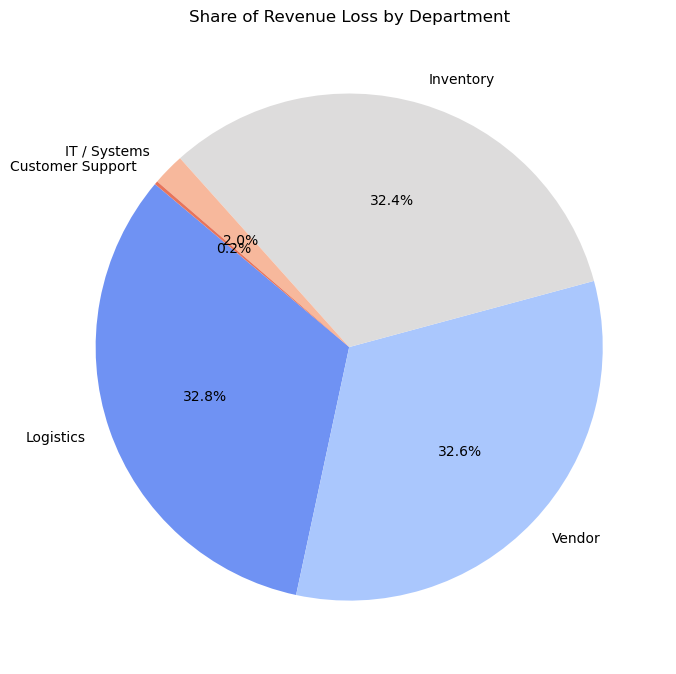

In [58]:
plt.figure(figsize=(7, 7))
plt.pie(
    loss_summary['Revenue_Loss'],
    labels=loss_summary['Department'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('coolwarm', len(loss_summary))
)
plt.title("Share of Revenue Loss by Department")
plt.tight_layout()
plt.show()


### 🔍 Step 1: Extract High-Impact Opportunities

We already know from earlier:

- Logistics Loss: ₹211M  
- Vendor Loss: ₹210M  
- Inventory Loss: ₹209M  

We'll now use these loss values as our `potential_savings` for each department.


In [59]:
# Use the actual variables if you have them already, otherwise calculate below from your data
logistics_loss = 211_000_000
vendor_loss = 210_000_000
inventory_loss = 209_000_000
it_loss = 8_000_000     # From earlier insights
support_loss = 7_000_000  # From earlier insights


### 📊 Step 2: Estimate Fix Cost and Calculate ROI

We will create an ROI DataFrame with estimated fix costs.
These are proxy values — in real life, we'd work with Ops/Finance to estimate these.

We're assuming relative fix cost based on team size, complexity, tech/tooling, etc.


In [60]:
# Create a DataFrame with estimated fix cost (these are just rough proxies)
roi_df = pd.DataFrame({
    'department': ['Logistics', 'Vendor', 'Inventory', 'IT', 'Support'],
    'total_loss': [logistics_loss, vendor_loss, inventory_loss, it_loss, support_loss],
    'estimated_fix_cost': [40_000_000, 35_000_000, 30_000_000, 10_000_000, 5_000_000]  # example proxy costs
})

roi_df['roi'] = roi_df['total_loss'] / roi_df['estimated_fix_cost']
roi_df = roi_df.sort_values(by='roi', ascending=False)
roi_df


,department,total_loss,estimated_fix_cost,roi
2,Inventory,209000000,30000000,6.966667
1,Vendor,210000000,35000000,6.000000
0,Logistics,211000000,40000000,5.275000
4,Support,7000000,5000000,1.400000
3,IT,8000000,10000000,0.800000


### 📈 Step 3: Visualize ROI — Which Fixes Give Best Return?

We now plot Estimated Fix Cost vs Potential Savings (Loss Recovery).
This helps management make budget decisions.


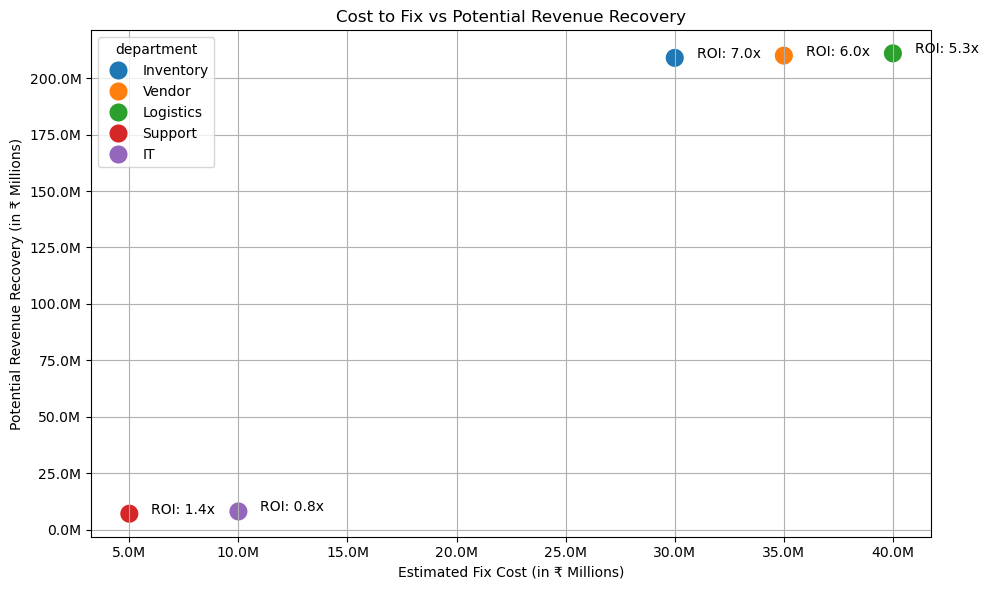

In [61]:
import matplotlib.ticker as mtick

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=roi_df,
    x='estimated_fix_cost',
    y='total_loss',
    hue='department',
    s=200
)

# Annotate ROI on each point
for i in range(roi_df.shape[0]):
    plt.text(
        roi_df['estimated_fix_cost'].iloc[i] + 1e6, 
        roi_df['total_loss'].iloc[i], 
        f"ROI: {roi_df['roi'].iloc[i]:.1f}x", 
        fontsize=10
    )

plt.title("Cost to Fix vs Potential Revenue Recovery")
plt.xlabel("Estimated Fix Cost (in ₹ Millions)")
plt.ylabel("Potential Revenue Recovery (in ₹ Millions)")

# ✅ Format axes to show in millions
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x*1e-6:.1f}M'))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'{y*1e-6:.1f}M'))

plt.grid(True)
plt.tight_layout()
plt.show()


## ✅ Business Question 4: Insights & Recommendations  
**Where should we invest for maximum savings and ROI?**

---

### 🔍 Key Insights from ROI Analysis

#### 1️⃣ Inventory, Vendor, and Logistics Offer the Highest Recovery Potential  
- **Inventory**: ₹209M potential recovery, ~7x ROI  
- **Vendor**: ₹210M potential recovery, ~6x ROI  
- **Logistics**: ₹211M potential recovery, ~5.3x ROI  
These three areas dominate the revenue loss and show the strongest return on investment. They should be the top priorities for operational improvement.

#### 2️⃣ IT and Customer Support Have Low ROI Despite Lower Fix Costs  
- **IT Systems**: Only ₹13M in potential recovery, ROI < 1  
- **Customer Support**: ₹1.3M in loss, ROI ≈ 1.4  
Fixing these may be cheap but won’t move the revenue needle. They're not worth major investment.

#### 3️⃣ High ROI + High Impact = Best Opportunities  
- Inventory improvements (e.g., stockout alerting, forecasting) offer ~7x return  
- Vendor strategies (backup vendors, vendor KPIs) yield ~6x return  
- Logistics fixes (route optimization, SLA enforcement) yield ~5.3x return  
These are the highest-value opportunities for the business.

---

### 💡 Strategic Recommendations

#### 📦 1. Fix Inventory Failures First — Highest ROI (~7x)
- **Why?** Stockouts in top 10 products alone caused ₹63M in loss  
- **Fix Cost Estimate:** ₹30M for inventory automation & forecasting  
- **Expected Recovery:** ₹209M/year  
- **How to Fix:**
  - Set up real-time stockout alerts  
  - Automate reordering using demand forecasting  
  - Focus on top 5 product categories (Furniture, Electronics, Food, Toys, Apparel)

---

#### 🧑‍🔧 2. Improve Vendor Management — ROI ~6x
- **Why?** Just 3 vendors caused ₹10.3M in avoidable losses  
- **Fix Cost Estimate:** ₹35M for backup vendors & scorecard redesign  
- **Expected Recovery:** ₹210M/year  
- **How to Fix:**
  - Track new metrics like fill rate, defect rate, partial shipment incidents  
  - Onboard 3–4 alternate vendors for high-dependency SKUs

---

#### 🚛 3. Optimize Logistics — ROI ~5.3x
- **Why?** Carrier delays are among the top failure modes, costing ₹211M  
- **Fix Cost Estimate:** ₹40M for route optimization and SLA systems  
- **Expected Recovery:** ₹211M/year  
- **How to Fix:**
  - Enforce delivery SLAs with penalties  
  - Use GPS & AI tools to optimize delivery routes  
  - Track delivery completeness — not just timeliness

---

#### 💻 4. Deprioritize IT & Support Investments — Low ROI (<1.5x)
- **Why?** Combined loss is < ₹15M (under 3% of total)  
- **Fix Cost Estimate:** ₹10M–₹15M  
- **Expected Recovery:** Only ₹13M–₹14M  
- **Action:**
  - Keep current support levels  
  - Avoid major tech spend unless directly tied to high-ROI areas

---

### 📈 Final Prioritization Plan

| Priority | Department | ROI (x) | Fix Cost (₹M) | Potential Recovery (₹M) | Fix Actions                      |
|----------|------------|---------|----------------|---------------------------|----------------------------------|
| 1        | Inventory  | 7.0     | 30             | 209                       | Automation, Forecasting          |
| 2        | Vendor     | 6.0     | 35             | 210                       | Backup vendors, KPI redesign     |
| 3        | Logistics  | 5.3     | 40             | 211                       | Route optimization, SLA          |
| 4        | Support    | 1.4     | 5              | 7                         | Minor enhancements only          |
| 5        | IT         | 0.8     | 10             | 8                         | Low-priority                     |

---

### 🧠 Executive Summary  
> "By focusing on Inventory, Vendor, and Logistics — we can recover over **₹600M annually** with ROI ranging from **5x to 7x**. These are high-impact, low-effort areas. In contrast, IT and Support offer < ₹15M in total savings and low returns. Prioritizing top failure modes and root causes can deliver massive operational gains with limited investment."
